# Detección de comentarios tóxicos de contexto futbolístico en Twitter

#### Estudiantes

* Edgar Piña Cuentas
* Fernando Andres Gomez Gonzalez

**Pregunta de investigación**

* ¿Es posible identificar la toxicidad en las opiniones de los usuarios de Twitter en español sobre el futbol?

**Hipótesis**

* Las opiniones toxicas en torno al futbol de los usuarios de Twitter en español suelen tener elementos característicos que hacen posible su identificación por medio de un modelo de Machine Learning


# Librerias

In [1488]:
import io
import sys
PATH = "./Datos/"
sys.path.append(PATH) if PATH not in list(sys.path) else None
import json
import codecs
import pandas as pd
import seaborn as sns
import numpy as np

# Visualización - Graficas
import matplotlib.pyplot as plt
import missingno as msno

#Procesamiento de datos
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion

#Modelos
from sklearn import svm
from sklearn.linear_model import LogisticRegression

#Metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,accuracy_score,roc_curve,roc_auc_score


from text_processing import TextProcessing as tp

# Contenido del Dataset

#### El dataset (copus) esta formado por:

* **id**: Numero de identificaion del tweet
* **lang**: Lenguaje del tweet
* **text**: Contenido del tweet
* **user_mentions**: Número de usuarios mencionados en el tweet
* **polaridad**: Indica que tipo de emocion se expresa en el tweet

# Lectura de Datos

In [1490]:
data=json.load(codecs.open(PATH + 'data.json', 'r', 'utf-8-sig'))
df = pd.json_normalize(data['tweets'])
#df=pd.DataFrame(data, )
df

,id,lang,text,user_mentions,polaridad
0,1438611805794979800,es,#Futbol #Corrientes: En Mercedes no le permite...,0,toxico
1,1438611790535921700,es,Renovación más cerca: reunión entre Mendes y e...,0,normal
2,1438611787092570000,es,Inazuma va de futbol y los nazis jugaban al fu...,0,toxico
3,1438611775830777900,es,Que manija tengo de ver en vivo al fútbol cham...,0,normal
4,1438611707174215700,es,SE VE HETERO FUTBOL FUTBOK FUTBOL SIEMPRE FUTBOL,0,toxico
...,...,...,...,...,...
395,1463716939931476000,es,@SC_ESPN Jajajaja jajajaja jajajaja jajajaja c...,1,toxico
396,1463625816684712000,es,"Barcelona, Dortmund, Atlético Madrid... la Eur...",0,toxico
397,1463721737024061400,es,@AtleticoCuba Ysuerte contra barca en la Europ...,1,toxico
398,1463722226340053000,es,"@BlxckNews Es obvio lo que sienten, en su mejo...",1,toxico


## Analisis de Datos

In [1491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             400 non-null    int64 
 1   lang           400 non-null    object
 2   text           400 non-null    object
 3   user_mentions  400 non-null    int64 
 4   polaridad      400 non-null    object
dtypes: int64(2), object(3)
memory usage: 15.8+ KB


### Identificion de Datos Nulos

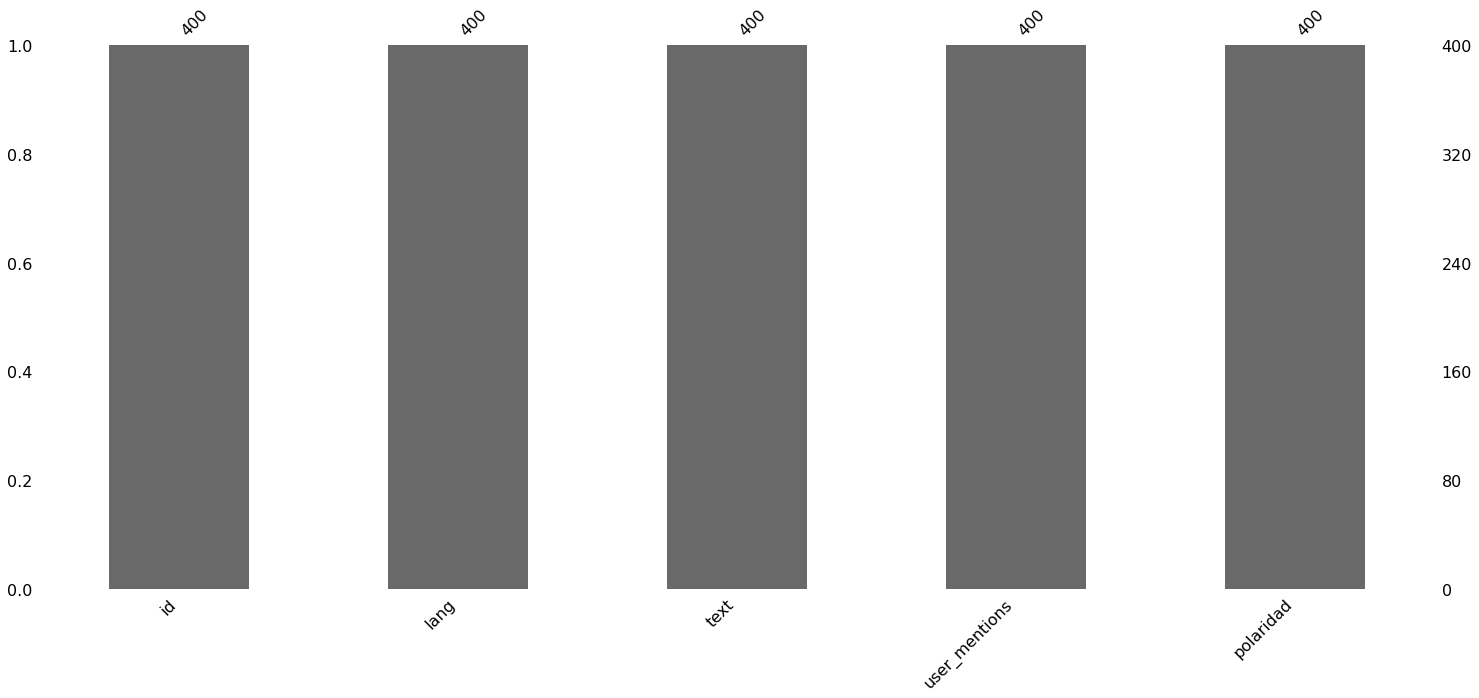

In [1492]:
## Analisis de valores nulos
p = msno.bar(df)

### Identificacion de datos repetidos

In [1493]:
#Verificar filas duplicadas
y=0
b=0
for i in df['text'].duplicated():
    if i==True:
        y+=1
        print(b)
    b+=1
print("Hay",y, "datos repetidos.")

Hay 0 datos repetidos.


### Conteo de valores objetivo

In [1494]:
#Conteo de tweets por partido
tweet_by_class = df.groupby("polaridad", as_index=False)['text'].count()
tweet_by_class

,polaridad,text
0,normal,200
1,toxico,200


### Frecuencia de las clases objetivo 

C:\Users\black\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


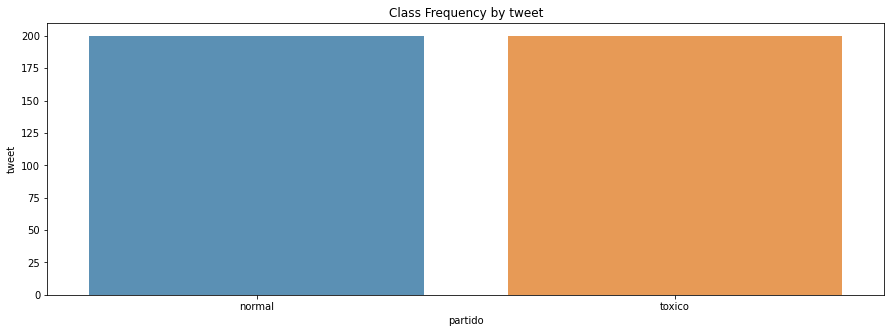

In [1495]:
#Frecuencia de clases
plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class['polaridad'].values, tweet_by_class['text'].values, alpha=0.8)
plt.title('Class Frequency by tweet')
plt.ylabel('tweet', fontsize=10)
plt.xlabel('partido', fontsize=10)
plt.show()

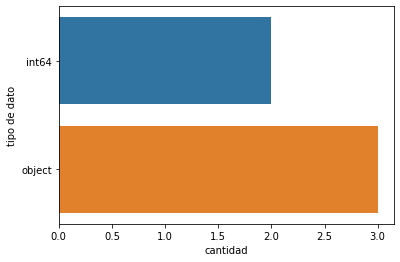

In [1496]:
## distribución y balance en el tipo de datos
df_scrubbed = df.copy(deep = True)
sns.countplot(y=df_scrubbed.dtypes.map(str))
plt.xlabel("cantidad")
plt.ylabel("tipo de dato")
plt.show()

# Tratamiento de datos

## Label encoding para la variable objetivo

* Normal: 0
* Toxico: 1

In [1497]:
#Label enconding para variable objetivo
#1-Toxico
#0-Normal
my_label = preprocessing.LabelEncoder()   
df['polaridad']=my_label.fit_transform(df['polaridad'])   
df

,id,lang,text,user_mentions,polaridad
0,1438611805794979800,es,#Futbol #Corrientes: En Mercedes no le permite...,0,1
1,1438611790535921700,es,Renovación más cerca: reunión entre Mendes y e...,0,0
2,1438611787092570000,es,Inazuma va de futbol y los nazis jugaban al fu...,0,1
3,1438611775830777900,es,Que manija tengo de ver en vivo al fútbol cham...,0,0
4,1438611707174215700,es,SE VE HETERO FUTBOL FUTBOK FUTBOL SIEMPRE FUTBOL,0,1
...,...,...,...,...,...
395,1463716939931476000,es,@SC_ESPN Jajajaja jajajaja jajajaja jajajaja c...,1,1
396,1463625816684712000,es,"Barcelona, Dortmund, Atlético Madrid... la Eur...",0,1
397,1463721737024061400,es,@AtleticoCuba Ysuerte contra barca en la Europ...,1,1
398,1463722226340053000,es,"@BlxckNews Es obvio lo que sienten, en su mejo...",1,1


## Separacion de datos en entrenamimento y prueba
(Proporcion de 70-30)

In [1498]:
test = pd.DataFrame()
train = df
size = round(round(df.shape[0]*0.5)/5)
for typ in list(df['polaridad'].dropna().unique()):
    samples = df[df['polaridad'] == typ].sample(size)
    test = test.append(samples)
    train = train.drop(samples.index)
test = test.reset_index()
train = train.reset_index()

### Dataset de prueba

In [1499]:
del test["index"]
test

,id,lang,text,user_mentions,polaridad
0,1463216898674409477,es,Decir que obtuvieron el mejor resultado en 17 ...,0,1
1,1463378680432889860,es,Sumado a que manejan como el reverendo ojete y...,0,1
2,1462883763940040705,es,@kike_mateu @cvenco Pero tus calumnias siempre...,2,1
3,1462887060868636675,es,@jesuscardozo_ @Doctor_Futbol Llevan llorando ...,2,1
4,1462883504723828739,es,@aleziito17 @CuartelB Ósea nunca van a ir al e...,2,1
...,...,...,...,...,...
75,1463709572342947800,es,@Kruyffixz_ @GxlDeIlias @GaspxJosip Pues es q ...,3,0
76,1462969353528246272,es,que hace el juez de línea jajdjdhsja???,0,0
77,1463246794024968198,es,Quiero ver la IMAGEN en la que sale el balón. ...,0,0
78,1462809630145351690,es,Todo el futbol Argentino quiere que hoy ascien...,0,0


C:\Users\black\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


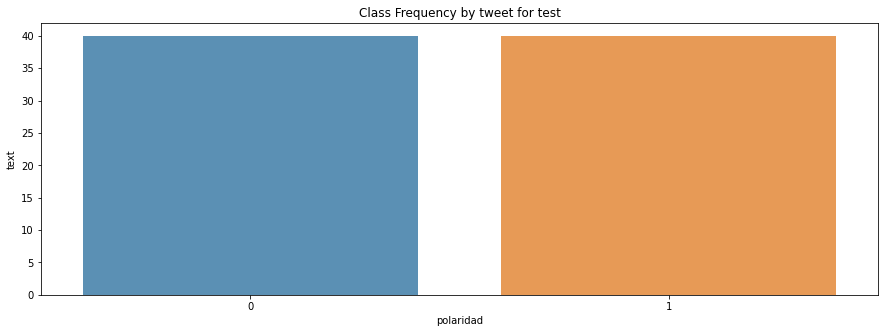

In [1500]:
tweet_by_class_test = test.groupby("polaridad", as_index=False)['text'].count()

plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class_test['polaridad'].values, tweet_by_class_test['text'].values, alpha=0.8)
plt.title('Class Frequency by tweet for test')
plt.ylabel('text', fontsize=10)
plt.xlabel('polaridad', fontsize=10)
plt.show()

### Dataset de entrenamiento

In [1501]:
del train["index"]
train

,id,lang,text,user_mentions,polaridad
0,1438611805794979800,es,#Futbol #Corrientes: En Mercedes no le permite...,0,1
1,1438611790535921700,es,Renovación más cerca: reunión entre Mendes y e...,0,0
2,1438611787092570000,es,Inazuma va de futbol y los nazis jugaban al fu...,0,1
3,1438611775830777900,es,Que manija tengo de ver en vivo al fútbol cham...,0,0
4,1438611707174215700,es,SE VE HETERO FUTBOL FUTBOK FUTBOL SIEMPRE FUTBOL,0,1
...,...,...,...,...,...
315,1463717381864308700,es,Lo fans d barza son una vaina. Una lloradera p...,0,1
316,1463625816684712000,es,"Barcelona, Dortmund, Atlético Madrid... la Eur...",0,1
317,1463721737024061400,es,@AtleticoCuba Ysuerte contra barca en la Europ...,1,1
318,1463722226340053000,es,"@BlxckNews Es obvio lo que sienten, en su mejo...",1,1


C:\Users\black\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


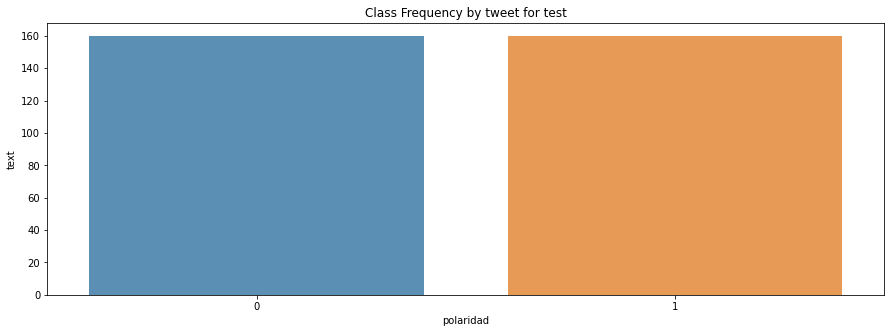

In [1502]:
tweet_by_class_test = train.groupby("polaridad", as_index=False)['text'].count()

plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class_test['polaridad'].values, tweet_by_class_test['text'].values, alpha=0.8)
plt.title('Class Frequency by tweet for test')
plt.ylabel('text', fontsize=10)
plt.xlabel('polaridad', fontsize=10)
plt.show()

## Limpieza del corpus

In [1503]:
#Limpieza de tweets de prueba
x_test = [tp.transformer(row, True) for row in test['text'].tolist()]
y_test = test["polaridad"]
len(x_test), len(y_test)

(80, 80)

In [1504]:
#Limpieza de tweets de entrenamiento
x_train = [tp.transformer(row, True) for row in train['text'].tolist()]
y_train = train["polaridad"]
len(x_train), len(y_train)

(320, 320)

## Tecnicas de extraccion de caracteristicas

In [1506]:
#TF-IDF
tfIdfVectorizer=TfidfVectorizer(ngram_range=(1,3), min_df=10, max_df = 0.9)

#Bow of n-gram
bow = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=10, max_df = 0.9)

## Union de caracteristicas

In [1507]:
preprocessor = FeatureUnion([
    ('tfidf_vector', tfIdfVectorizer),
    ('bow', bow)
    
])

preprocessor.fit(x_train)

FeatureUnion(transformer_list=[('tfidf_vector',
                                TfidfVectorizer(max_df=0.9, min_df=10,
                                                ngram_range=(1, 3))),
                               ('bow', CountVectorizer(max_df=0.9, min_df=10))])

In [1508]:
x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)

In [1509]:
x_train

<320x45 sparse matrix of type '<class 'numpy.float64'>'
	with 1454 stored elements in Compressed Sparse Row format>

In [1510]:
x_test

<80x45 sparse matrix of type '<class 'numpy.float64'>'
	with 321 stored elements in Compressed Sparse Row format>

# Modelos

## Definicion de los modelos

In [1511]:
ML_models = {}
# Indice - nombre
model_index = ['LR','SVM']
# Arranque inicial de los modelos con parametros
model_sklearn = [LogisticRegression(solver='liblinear'),
                 svm.SVC(kernel='linear', C=1, probability=True)]

## Entrenamiento de los modelos

In [1512]:
# Entrenamiento
for name,model in zip(model_index,model_sklearn):
    # Entrenamiento del modelo (Fit)
    ML_models[name] = model.fit(x_train,y_train)
print(ML_models)

{'LR': LogisticRegression(solver='liblinear'), 'SVM': SVC(C=1, kernel='linear', probability=True)}


# Metricas

## Evaluacion general de los modelos a traves del score

In [1513]:
# Evaluación de resultados y metricas
model_summary = []
for name,model in zip(model_index,model_sklearn):
    # Predicción con el conjunto de datos de prueba
    preds = model.predict(x_test)
    # Desempeño básico
    print(name)
    print('Desempeño básico: '+str(model.score(x_test,y_test))+'\n')
    # Resultados guardados
    fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(x_test)[:,1])
    model_summary.append([name,
                          confusion_matrix(y_test,preds),classification_report(y_test,preds),
                          accuracy_score(y_test,preds),
                          f1_score(y_test,preds,average='weighted'),
                          {'roc':roc_auc_score(y_test,model.predict_proba(x_test)[:,1]),'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}])

LR
Desempeño básico: 0.6875

SVM
Desempeño básico: 0.7



## Matriz de confusion

In [1514]:
def show_info_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, xticklabels=["Positivo (1)","Negativo (0)"], yticklabels=["Positivo (1)","Negativo (0)"], annot=True, fmt="d");
    plt.title("Matriz de confusión para " + title.upper())
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
    plt.show()

LR


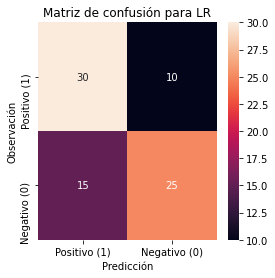

SVM


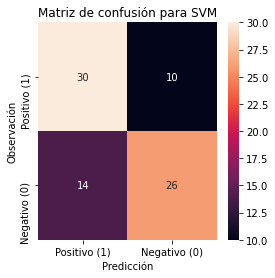

In [1515]:
for model in model_summary:
    print(model[0])
    show_info_confusion_matrix(model[1], model[0])

## Reporte de clasificacion

In [1516]:
for model in model_summary:
    print(model[0])
    print('Accuracy: '+str(model[3]))
    print('F1-Score: '+str(model[4]))
    print(model[2])

LR
Accuracy: 0.6875
F1-Score: 0.6862745098039216
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        40
           1       0.71      0.62      0.67        40

    accuracy                           0.69        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.69      0.69      0.69        80

SVM
Accuracy: 0.7
F1-Score: 0.6992481203007519
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        40
           1       0.72      0.65      0.68        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80

